# Clustering to Customer Segementation

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv("C:/Users/warshape/Desktop/cleaned_data.csv")

In [10]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        397884 non-null  int64  
 1   InvoiceNo    397884 non-null  int64  
 2   StockCode    397884 non-null  object 
 3   Description  397884 non-null  object 
 4   Quantity     397884 non-null  int64  
 5   InvoiceDate  397884 non-null  object 
 6   UnitPrice    397884 non-null  float64
 7   CustomerID   397884 non-null  int64  
 8   Country      397884 non-null  object 
 9   TotalPrice   397884 non-null  float64
 10  Year         397884 non-null  int64  
 11  Month        397884 non-null  int64  
 12  Day          397884 non-null  int64  
 13  Hour         397884 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 42.5+ MB


(None,
    index  InvoiceNo StockCode                          Description  Quantity  \
 0      0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1      1     536365     71053                  WHITE METAL LANTERN         6   
 2      2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3      3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4      4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
            InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
 0  2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
 1  2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
 2  2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
 3  2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
 4  2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
 
    Year  Month  Day  Hour  
 0  20

### RFM Based Customer Segementation

- 1. Total Spending (TotalPrice)
- 2. Frequency (Number of purchases)
- 3. Recency (Days since last purchase)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency (Days since last purchase)
latest_date = df['InvoiceDate'].max()
df['Recency'] = (latest_date - df['InvoiceDate']).dt.days

# Frequency: Count number of purchases per customer
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Monetary: Total Spending
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Merge Recency, Frequency, and Monetary
rfm = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


## Data Scaling

In [12]:
# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

## Elbow Method to Find Optimal K

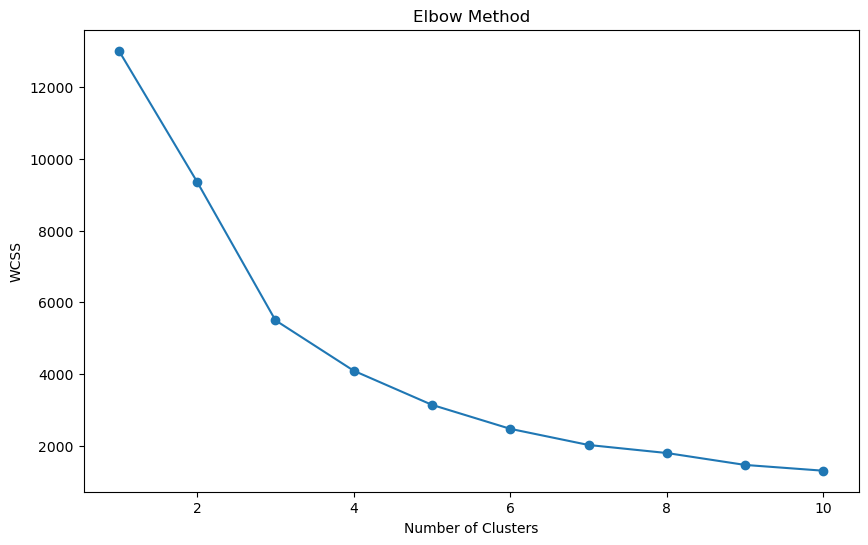

In [13]:
# Use the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## Apply K-Means Clustering

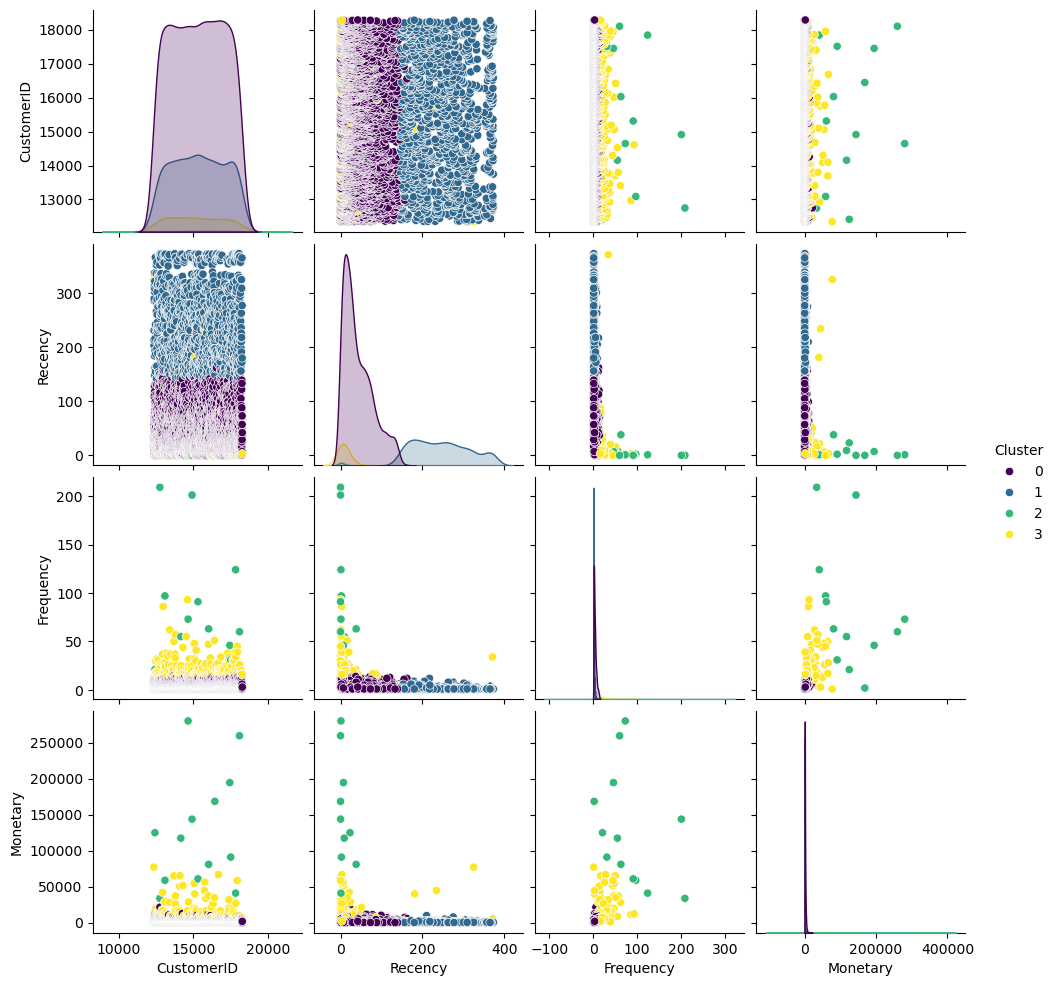

In [14]:
# Based on the elbow method, choose the optimal K here its 3 or 4 
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize the Clusters
sns.pairplot(rfm, hue='Cluster', palette='viridis')
plt.show()


In [15]:
# Merge Cluster labels into the original DataFrame
df = pd.merge(rfm, rfm[['CustomerID', 'Cluster']], on='CustomerID', how='left')

df.head(20)

,CustomerID,Recency,Frequency,Monetary,Cluster_x,Cluster_y
0,12346,325,1,77183.60,3,3
1,12347,1,7,4310.00,0,0
2,12348,74,4,1797.24,0,0
3,12349,18,1,1757.55,0,0
4,12350,309,1,334.40,1,1
5,12352,35,8,2506.04,0,0
6,12353,203,1,89.00,1,1
7,12354,231,1,1079.40,1,1
8,12355,213,1,459.40,1,1
9,12356,22,3,2811.43,0,0


## Clusters Interpretation

🟣 **Cluster 0 (Purple)**
- Customers with **high recency** (recent buyers).
- **Low frequency** and **low monetary value**.
- Likely **new or one-time customers**.

🔵 **Cluster 1 (Blue)** 
- Customers with **moderate recency** and **frequency**.
- **Low to medium monetary value**.
- These customers are **regular buyers but not high spenders**.

🟢 **Cluster 2 (Green)**
- Customers with **low recency** (**inactive customers**).
- **High frequency** and **high monetary value**.
- These customers were **loyal high spenders but haven't purchased recently**.

🟡 **Cluster 3 (Yellow)**
- Customers with **low recency**, **high frequency**, and **very high monetary value**.
- This group represents **loyal VIP customers**.

---

## Insights
- **Cluster 0**: Target with **re-engagement campaigns**.
- **Cluster 1**: Represents **average customers** — offering **discounts** could increase spending.
- **Cluster 2**: Could benefit from **win-back campaigns** to make them active again.
- **Cluster 3**: Nurture with **loyalty programs and premium offers**.